# Building an Apache log analyzer with Pandas

Apache access logs are text files that record the activity of a web site. The analysis of log files provides useful insights for web masters and site owners. This example illustrates how to use the data analysis functions of Pandas to analize log files.

For this exercise we will need to import the following libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.parser import *

## Apache log files

Log files come in various formats which differ in the amount mof information registered in the log. The two most common formats are the 'common' and the 'combined'. For more details about apache log formats see <a href="https://httpd.apache.org/docs/2.2/en/logs.html">Apache's Log Files</a>. Here are a couple of examples:

Common format:<BR>
    <PRE>local - - [30/Mar/1995:20:28:05 -0700] "GET 6224.html HTTP/1.0" 200 2644</PRE>

Combined format:<BR>
    <PRE>192.168.0.1 - - [02/Jan/2018:07:20:02 -0500] "GET /index.html HTTP/1.1" 200 8813 "-" "Mozilla/5.0 (Linux; Android 7.0; PRA-LX3 Build/HUAWEIPRA-LX3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.91 Mobile Safari/537.36"</PRE>

The first element of a log line is the address or hostname of the client.<BR>
Next come the id and the user, usually not used and register as a '-'.<BR>
Then, we have the date and time enclosed between '[' and ']'.<BR>
The next element is the request, which comes enclosed in quotes.<BR>
Then we have a couple numbers, the http status code and the response size. In some cases, they may be registered as '-'.<BR>
In the combined format we have two additional elements, the referer and the user agent, both enclosed in quotes.

## Reading the log file

At first, the log lines may seem difficult to parse. Pandas simplifies thet task with the <a href="https://pandas.pydata.org/pandas-docs/stable/io.html#io-read-csv-table">read_csv function</a>, which supports many customization options. We are going to need the following:
<UL>
    <li><em>delim_whitespace=True</em>. Use whitespaces instead of commas as field separators.</li>
    <li><em>header=None</em>. Log files do no include a headers line.</li>
    <li><em>parse_dates={ 'dt': [3,4] }</em>. We are going to use columns 3 and 4 to parse the date.</li>
    <li><em>date_parser=apacheDateParser</em>. Our custom function to parse dates in the log's format.</li>
    <li><em>index_col=0</em>. Use the date-time field as the dataframe index</li>
    <li><em>names=['client','id','user','datetime','tz','request','status','size','referer','agent']</em>. Name the columns to make it easier to access and remember their meaning.</li>
    <li><em>converters={ 'status':myIntParser, 'size': myIntParser }</em>. We want to handle the status code and the document size as integers, but we need a custon function to handle the cases where the field is '-'.</li>
    <li><em>encoding='iso-8859-1'</em>. What encoding uses the log file. Most cases are either 'iso-8859-1' or 'utf-8'.</li>
    <li><em>dtype={ 'referer': object, 'agent': object }.</em>Specify the data type of the last columns. Important in the case of the common format, which does not contain this information.</li>
</UL>

So, lets define our custom functions for parsing integers and dates:

In [2]:
def apacheDateParser(x,y):
    return parse(x+' '+y, fuzzy=True)    


def myIntParser(x):
    try:
        # Throws a ValueError exception if is not a valid integer
        return int(x)
    except ValueError:
        return np.nan

And now we can read the log file into a Pandas <a href="https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html">Dataframe</a>.

In [3]:
data = pd.read_csv('<Path to your access_log file>', encoding='iso-8859-1',
    delim_whitespace=True, 
    header=None, 
    parse_dates={ 'dt': [3,4] },
    date_parser=apacheDateParser,
    index_col=0, 
    names=['client','id','user','datetime','tz','request','status','size','referer','agent'],
    converters={ 'status':myIntParser, 'size': myIntParser },
    dtype={ 'referer': object, 'agent': object } )

We can check how many rows and columns in the data with

In [4]:
print(data.shape)

(154754, 8)


And take a look at the data with

In [5]:
data.head()

,client,id,user,request,status,size,referer,agent
dt,,,,,,,,
1994-10-24 19:41:41,local,-,-,GET index.html HTTP/1.0,200,150,NaN,NaN
1994-10-24 19:41:41,local,-,-,GET 1.gif HTTP/1.0,200,1210,NaN,NaN
1994-10-24 19:43:13,local,-,-,GET index.html HTTP/1.0,200,3185,NaN,NaN
1994-10-24 19:43:14,local,-,-,GET 2.gif HTTP/1.0,200,2555,NaN,NaN
1994-10-24 19:43:15,local,-,-,GET 3.gif HTTP/1.0,200,36403,NaN,NaN


In this case the log file is in the common format and for this reason the referer and agent columns are empty.

We may also want to check that the type conversions work as expected

In [6]:
data.dtypes

client      object
id          object
user        object
request     object
status     float64
size       float64
referer     object
agent       object
dtype: object

We can check some basic statistics of the data, for example

The mean transfer size is

In [7]:
data['size'].mean()

14133.754770083728

and its standard deviation is

In [8]:
data['size'].std()

147597.44034731924

We can see that in some cases the size was not a valid value

In [9]:
data['size'][data['size'].isnull()].head()

dt
1994-10-24 19:49:01   NaN
1994-10-24 20:00:20   NaN
1994-10-24 20:16:26   NaN
1994-10-24 20:19:52   NaN
1994-10-24 20:21:21   NaN
Name: size, dtype: float64

When doing analysis on files with this kind of problems, be aware that there may be cases like this that introduce error in the results. For example if we count the number of size records we obtain

In [10]:
data['size'].count()

141769

Much lower than the number of rows in the table.

## Data analysis

### Grouping

Using a grouping criteria we can obtain statistics about groups of records that share certain characteristic. In this example, we are going to characterize the visits to the website by day of the week. So, we start by grouping the dataframe by weekday for counting the number is hits. In this case, any column will do for the counting.

In [11]:
grpHitsWDay = data[['id']].groupby(data.index.weekday, sort=False)

Observe that the groupby operation returns a DataFrameGroupBy object

In [12]:
grpHitsWDay

The indices attribute give us a good intuition of how groups are represented

In [13]:
grpHitsWDay.indices

{0: array([     0,      1,      2, ..., 140779, 140780, 140781]),
 1: array([   491,    492,    493, ..., 145383, 145384, 145385]),
 2: array([  1605,   1606,   1607, ..., 150382, 150383, 150384]),
 3: array([  3040,   3041,   3042, ..., 154751, 154752, 154753]),
 4: array([  5149,   5150,   5151, ..., 133443, 133444, 133445]),
 5: array([  7050,   7051,   7052, ..., 135442, 135443, 135444]),
 6: array([  7957,   7958,   7959, ..., 137781, 137782, 137783])}

each weekday (0,..,6) is an array that containts the rows of the dataframe that belong to the group. This is quite important because when computing any metric, we have to use functions that operate over the arrays of the corresponding rows.

For example, counting the number of elements in the array gives us the total hits of the respective day

In [14]:
grpHitsWDay.count()

,id
0,23079
1,27278
2,30223
3,28370
4,22746
5,11750
6,11308


Of course, it would be nicer if we give the days of the week the corresponding names and the column the name 'Hits'

In [15]:
hits = grpHitsWDay.count()
hits.index = [ 'Mon','Tue','Wed','Thu','Fri','Sat','Sun' ]
hits.columns = [ 'Hits' ]
hits

,Hits
Mon,23079
Tue,27278
Wed,30223
Thu,28370
Fri,22746
Sat,11750
Sun,11308


The method describe gives a basic statistical description of the 'Hits' metric

In [16]:
hits.describe()

,Hits
count,7.000000
mean,22107.714286
std,7714.410946
min,11308.000000
25%,17248.000000
50%,23079.000000
75%,27824.000000
max,30223.000000


Sometimes a picture is work a thousand words

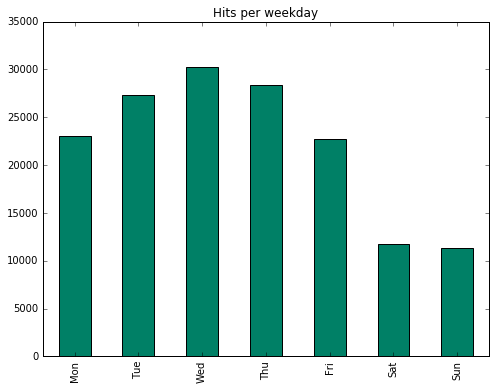

In [17]:
hits.plot(kind='bar', figsize=(8,6), colormap='summer', title='Hits per weekday', legend=False)
plt.show()

One may want a characterize several of the metrics at the same time. Let us characterize the behavior of hits and transferred bytes per weekday

In [18]:
grpWDay = data[ ['id','size'] ].groupby(data.index.weekday)

In this case, we want to count the number of hits and sum the number of bytes. The aggregate method allows passing the fuctions to apply to each column

In [19]:
stats = grpWDay.aggregate({ 'id':lambda x: x.count(), 'size':np.sum })
stats

,id,size
0,23079,357550472
1,27278,363178475
2,30223,335276077
3,28370,382002044
4,22746,288358842
5,11750,141023753
6,11308,136338617


A couple of notes:
<ul>
<li>The columns of a dataframe are NumPy arrays, therefore standard NumPy functions (such as np.sum) can be used.</li>
<li>A did not find a function that takes an array as argument and count the number of elements, but no problem, I created a lambda expression that takes the array as input and returns the result of invoking its count() method.</li>
</ul>

Of course, everything looks better with nicer names, so let us rename the columns and the indices

In [20]:
stats = grpWDay.aggregate({ 'id':lambda x: x.count(), 'size':np.sum }).rename(columns={'size':'Bytes', 'id':'Hits'})
stats.index=[ 'Mon','Tue','Wed','Thu','Fri','Sat','Sun' ]
stats

,Hits,Bytes
Mon,23079,357550472
Tue,27278,363178475
Wed,30223,335276077
Thu,28370,382002044
Fri,22746,288358842
Sat,11750,141023753
Sun,11308,136338617


Now let us plot both metrics

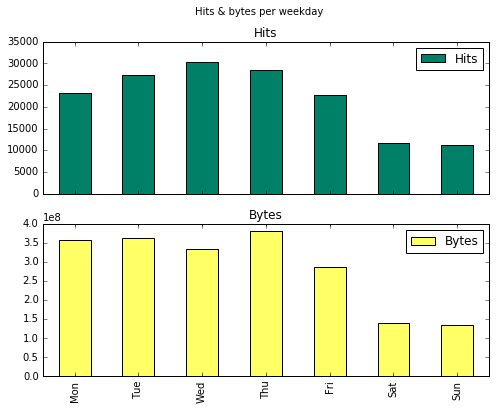

In [21]:
stats.plot(kind='bar', figsize=(8,6), colormap='summer', title='Hits & bytes per weekday', subplots=True)
plt.show()    

### Post-processing of the dataset

Sometimes, we can obtain additional information by doing some operations over the data. One good example is identifying the resources of the web site. Currently, the dataset containts a request column that gives the method, the resource and the protocol version

In [22]:
data['request'].head(10)

dt
1994-10-24 19:41:41    GET index.html HTTP/1.0
1994-10-24 19:41:41         GET 1.gif HTTP/1.0
1994-10-24 19:43:13    GET index.html HTTP/1.0
1994-10-24 19:43:14         GET 2.gif HTTP/1.0
1994-10-24 19:43:15         GET 3.gif HTTP/1.0
1994-10-24 19:43:17         GET 4.gif HTTP/1.0
1994-10-24 19:46:45    GET index.html HTTP/1.0
1994-10-24 19:46:45         GET 2.gif HTTP/1.0
1994-10-24 19:46:47         GET 3.gif HTTP/1.0
1994-10-24 19:46:50         GET 4.gif HTTP/1.0
Name: request, dtype: object

The HTTP protocol dictates that the three fields are separated by spaces and the request cannot contain any additional spaces. Thus a simple split would give us the three fields. Lets grab the resource and add an extra column to the dataframe

In [23]:
data['resource'] = data['request'].apply(lambda x: x.split()[1])
data['resource'].head(10)

dt
1994-10-24 19:41:41    index.html
1994-10-24 19:41:41         1.gif
1994-10-24 19:43:13    index.html
1994-10-24 19:43:14         2.gif
1994-10-24 19:43:15         3.gif
1994-10-24 19:43:17         4.gif
1994-10-24 19:46:45    index.html
1994-10-24 19:46:45         2.gif
1994-10-24 19:46:47         3.gif
1994-10-24 19:46:50         4.gif
Name: resource, dtype: object

Here we use the apply method, which invokes a function to each element of the array. We define a lambda function that takes the request string, makes a split and returns the element at position 1.

Well then, let us find the number of hits and bytes for each resource

In [24]:
grpRsc = data[ ['id','size'] ].groupby(data['resource'])
stats = grpRsc.aggregate({ 'id':lambda x: x.count(), 'size':np.sum }).rename(columns={'size':'XferBytes', 'id':'Hits'})
stats

,Hits,XferBytes
resource,,
1.gif,135,215140
10.html,146,309145
100.xbm,431,208472
1000.jpg,4,85464
1001.jpg,6,348228
1002.jpg,7,442470
1003.html,193,440049
1004.gif,135,60833
1005.gif,139,25021


It is commonly the case that we are interested in the top hitters. So, let us sort the information and grab the top ten hitters in descending order

In [25]:
sortedh = stats.sort_values(by='Hits', ascending=False)
sortedh.head(10)

,Hits,XferBytes
resource,,
index.html,36323,84635972
2.gif,7959,19739930
3.gif,7922,273815789
4.gif,4710,2055942
5.html,1715,1381601
93.gif,949,1863344
167.html,816,1008060
990.html,746,1457221
991.html,730,1266436


Observe that the top hits are not responsible for the most transferred bytes. Let us see this from the perspective of transferred bytes

In [26]:
sortedb = stats.sort_values(by='XferBytes', ascending=False)
sortedb.head(10)

,Hits,XferBytes
resource,,
3.gif,7922,273815789
743.qt,51,94375663
1176.ps,12,89993276
index.html,36323,84635972
1672.ps,19,77567724
795.qt,46,46502400
38.aiff,128,41866734
2203.jpg,112,38942392
836.ps,3,35567646


Now we now what to optimize to improve the bandwidth utilization of the website. How about plotting some of this information

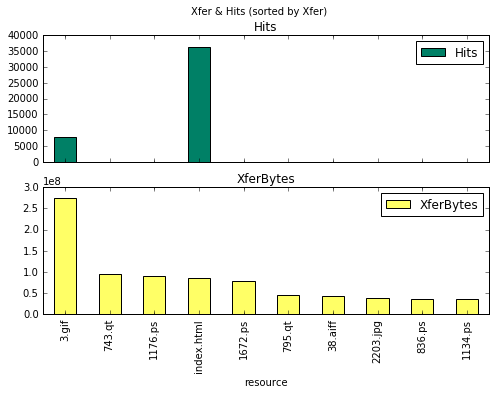

In [27]:
sortedb.head(10).plot(kind='bar', figsize=(8,5), colormap='summer', title='Xfer & Hits (sorted by Xfer)', subplots=True)
plt.show()

## To explore further

Pandas allows many different things with a few lines of code. Some interesting exercises could be the following:
<ul>
<li>Group the data using the status code. Determine what resources are causing the larger number of errors. These could reveal broken links or possible attacks on the web site.</li>    
<li>To keep log files not too large, web servers use some log rotation schemes. For analysis it may be necessary to have all the information in a single dataframe. This could be done using the <a href="https://pandas.pydata.org/pandas-docs/stable/merging.html">concat</a> or the <a href="https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.append.html#pandas.DataFrame.append">append</a> functions.</li>    
</ul>

## Source code

<a href="https://github.com/jmlon/PythonTutorials/blob/master/pandas/logAnalyzer.py">logAnalyzer.py</a> in GitHub